# Load Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate

# Load and Clean Dataframe

In [2]:
data = pd.read_table("GrainSizeDistribution.dat", sep="\s+")

In [12]:
data.drop(['distribution', '(source', 'US', 'Army',
       'Corps', 'of', 'Engineers)'], axis=1, inplace=True)
data.drop([0,1,2,3], axis=0, inplace=True)
data.rename(columns={"Sediment": "GrainSize_mm", "grain": "Percent", "size":"CumulativePercCoarser"}, inplace=True)
data = data.astype(np.float)

In [13]:
data['CumulativePercFiner'] = 100 - data['CumulativePercCoarser']

# --------- Question a ---------

### <span style="color:STEELBLUE">**GIVEN:**</span> grain size (mm)
### <span style="color:STEELBLUE">**FIND:**</span> mean and median diameter  
### <span style="color:STEELBLUE">**PRINCIPLES:**</span>
### Krumbien (1936) Phi Scale:
### $\phi = -\log_2 d$
### Otto (1939 and Inman (1952):
### $M_{d\phi} =  \frac{(\phi_{84} + \phi_{16})}2$
### $d_{mean} =  {2}^{-M_{d\phi}}$
### Sorting:
### $\sigma_{\phi} = \frac{(\phi_{84} - \phi_{16})}2$

### <span style="color:STEELBLUE">**SOLUTION:**</span>

In [14]:
# Add phi scale column
data['phi'] = -np.log2(data.GrainSize_mm)

In [15]:
data.head()

,GrainSize_mm,Percent,CumulativePercCoarser,CumulativePercFiner,phi
4,4.000,0.00,0.00,100.00,-2.000000
5,3.364,0.26,0.26,99.74,-1.750178
6,2.828,0.16,0.42,99.58,-1.499782
7,2.378,0.17,0.59,99.41,-1.249749
8,2.000,0.22,0.81,99.19,-1.000000


In [16]:
#Find percentiles

# Use Cumulative Percent Coarser and interpolate
x = [83.43, 93.35]
y = [2.498179, 2.746616]

phi_84 = np.interp(84, x, y)

x = [15.71, 20.16]
y = [1.000000, 1.251539]


phi_16 = np.interp(16, x, y)

In [17]:
phi_84

2.512454109879032

In [18]:
#Calculate d_mean:
M_dphi = (phi_84 + phi_16) / 2
d_mean = np.power(2, (-M_dphi))

In [19]:
d_mean

0.29434432760858464

### Mean grain size is 0.29 mm

In [20]:
# Calculate d_median:
# phi_50 = np.percentile(data.phi, 50)
# d_median = np.power(2, (-phi_50))

x = [36.69, 54.10]
y = [1.751465, 2.000000]

phi_50 = np.interp(50, x, y)
d_median = np.power(2, (-phi_50))

In [21]:
d_median

0.26035088344971896

### Median grain size is 0.26 mm

In [22]:
# Calculate sorting (standard deviation):
std_phi = (phi_84 - phi_16) / 2

In [23]:
std_phi
# std_phi >= 1, BETWEEN WELL AND POORLY SORTED

0.7480308403327744

### Because the standard deviation (phi units) is 0.75, it is between well and poorly sorted

# ------ ---  Question b --------- 

### <span style="color:STEELBLUE">**GIVEN:**</span> grain size (mm), std_phi (standard deviation in phi units) = 0.75, M_dphi (mean in phi units) = 1.76
### <span style="color:STEELBLUE">**FIND:**</span> Plot grain size (in mm) distribution together with the log-normal cumulative distribution function (CDF)  
### <span style="color:STEELBLUE">**PRINCIPLES:**</span>
### Equation 2.2 log-normal probability density function:
### $f(\phi) = \frac{1}{\sigma_\phi \sqrt{2\pi}}e^-{\frac{{(\phi-\mu_\phi)}^2}{2\sigma_\phi^2}}$
### Equation 2.3 CDF:
### $P[\phi < \phi_g] = \int_{-\infty}^{\phi_g} f(\phi)d\phi$

### <span style="color:STEELBLUE">**SOLUTION (CALC CDF AND PLOT):**</span>

In [24]:
g = data['phi']

# PDF 
y = ((1/(std_phi*np.sqrt(2*np.pi)))*(np.e**((-(g - M_dphi)**2)/(2 * (std_phi**2)))))

# CDF
y_int = integrate.cumtrapz(y, initial = 0)

In [25]:
# convert from phi to mm 
y_int_mm = np.power(2, (-y_int))

Text(0.5, 1.0, 'Grain size (mm) distribution together with the \n log-normal cumulative distribution function (CDF)')

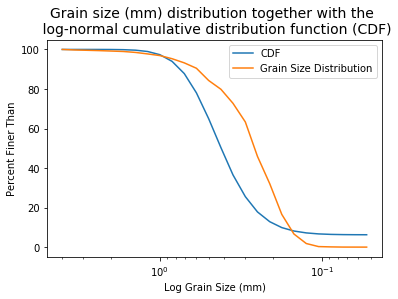

In [26]:
x = data['GrainSize_mm']

y1 = y_int_mm * 100
y2 = data['CumulativePercFiner']

plt.plot(x,y1, label = "CDF")
plt.plot(x,y2, label = "Grain Size Distribution")

plt.legend()
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Log Grain Size (mm)')
plt.ylabel("Percent Finer Than")
plt.title('Grain size (mm) distribution together with the \n log-normal cumulative distribution function (CDF)', fontsize = 14)


## Discussion:
The grain size distribution is slight skewed towards smaller grain sizes. The curve is smooth and suggests that the sample is well-graded. 

# --------- Question c --------- 

### <span style="color:STEELBLUE">**GIVEN:**</span> $s_{quartz} = 2.65$;  $\rho_{seawater} = 1025  kg/m^3$; $\mu_{seawater} = 0.00114 Ns/m^2$
### <span style="color:STEELBLUE">**FIND:**</span> Plot the fall velocity (cm/s) in seawater versus percent finer than
### <span style="color:STEELBLUE">**PRINCIPLES:**</span>
### Equation 2.11 fall velocity:
### $ w = \sqrt{\frac{4(\rho_s - \rho) g d}{3 \rho C_D}}$ 
### Reynolds Number:
### $Re = \frac{\rho w d}{\mu}$
### Equation 2.13 approximation for a sphere's drag coefficient :
### $ C_D = \frac{24}{Re} \sqrt{(1 + \frac{3 Re}{16})}$  



### <span style="color:STEELBLUE">**SOLUTION: Sample Calc; d = 0.5 mm**</span>

In [43]:
#define parameters
d = 0.5

SG_s = 2.65 #specific gravity for quartz
g = 9.81 #gravitational accel in m/s**2
rho_w = 1030 #density of seawater in kg/m**3 at 15.6 degC and 35 ppt from Fundamentals of Fluid Mechanics by Munson et al.
mu = 1.2*10**(-3) #dynamic viscoity of water in N*s/m**2 rom Fundamentals of Fluid Mechanics by Munson et al.

In [44]:
sol = [0]
solindex = 0

iteration = 0
C_D = 10 # input initial CD guess
C_D = initial_guess_C_D

_break = True

while _break == True: 
    previous_guess = C_D
    w = ((4*(SG_s-1)*g*d)/(3*C_D)* (1/1000))**(0.5)
    Re = rho_w*(1/1000)*w*d/mu
    C_D = 24/Re*(1+(3*Re/16))**(0.5)
    error = abs(C_D-previous_guess) # calculate error
    if (error <= 0.000000001) or (error == 0): # break when the error threshold is met
        _break = False
    iteration += 1

sol[solindex] = w #converged solution added
solindex += 1 

In [45]:
sol[0] # in m/s

0.07341827087628008

___________

In [30]:
# Base fall velocity 
w = np.sqrt((4/3)* (2.65 - 1) * 9.81 * (0.5) * (1/1000))
print ("w is   {} * C_D ^ (- 1/2) m/s".format(w))

w is   0.1038797381590847 * C_D ^ (- 1/2) m/s


In [31]:
# Reynolds number (sewater)
# Density of seawater 1025
# Viscosity of seawater .00114

Re = ((1025) * (0.5) * (1/1000)) / (0.00114)
print ("Re is   {} * w (m/s)".format(Re))

Re is   449.5614035087719 * w (m/s)


#### Iterate 1

In [32]:
# Iterate with C_D, guess C_D = 2
w2 = w / np.sqrt(2)
print ("w2 is {} m/s".format(w2))

w2 is 0.07345406728017176 m/s


In [33]:
Re2 = (Re * w2)
print ("Re2 is {}".format(Re2))

Re2 is 33.02211357990178


In [34]:
CD = (24/Re2) * np.sqrt(1 + ((3*Re2)/(16)))
print ("CD is {}".format(CD))

CD is 1.9490390236439714


---------

#### Iterate 2

In [35]:
# Iterate with C_D, C_D = 1.1055931228942726
w3 = (w / np.sqrt(CD))
print ("w3 is {} m/s".format(w3))

w3 is 0.07440816234970565 m/s


In [36]:
Re3 = (Re * w3)
print ("Re3 is {}".format(Re3))

Re3 is 33.45103789844223


In [37]:
CD2 = (24/Re3) * np.sqrt(1 + ((3*Re3)/(16)))
print ("CD2 is {}".format(CD2))

CD2 is 1.9347758504361243


-------

### Iterate 3

In [38]:
# Iterate with C_D, C_D = 1.5191487630679061

w4 = (w / np.sqrt(CD2))
print ("w4 is {} m/s".format(w4))

w4 is 0.07468192732197794 m/s


In [39]:
Re4 = (Re * w4)
print ("Re4 is {}".format(Re4))

Re4 is 33.5741120636085


In [40]:
CD3 = (24/Re4) * np.sqrt(1 + ((3*Re4)/(16)))
print ("CD3 is {}".format(CD3))

CD3 is 1.9307395831211043


### For the sample calculation, with d = 0.5 mm, the fall velocity is 0.075 m/s or 7.5 cm/s

-----------

# Solve for all data 

In [41]:
grains = data['GrainSize_mm'] 

In [44]:
w_result = []
Re_result = []

for g in grains:
    w = np.sqrt((4/3)* (2.65 - 1) * 9.81 * (g) * (1/1000))
    w_result.append(w)
    Re = ((1025) * (g) * (1/1000)) / (0.00114)
    Re_result.append(Re)

In [45]:
# Iterate
CD=10
w2_result = []
for w in w_result:
    w2 = w / np.sqrt(CD)
    w2_result.append(w2)


In [46]:
df = pd.DataFrame({'w_base_m_s': w_result, 'Re_base':Re_result, 'w2_m_s': w2_result})

In [47]:
df['Re2'] = df['Re_base'] * df['w2_m_s']

In [48]:
df['CD2'] = (24/df['Re2']) * np.sqrt(1 + ((3*df['Re2'])/(16)))

In [49]:
df['w3_m_s'] = df['w_base_m_s'] / np.sqrt(df['CD2'])

In [50]:
df['Re3'] = df['Re_base'] * df['w3_m_s']

In [51]:
df['CD3'] = (24/df['Re3']) * np.sqrt(1 + ((3*df['Re3'])/(16)))

In [52]:
df['w4_m_s'] = df['w_base_m_s'] / np.sqrt(df['CD3'])

In [53]:
df['Re4'] = df['Re_base'] * df['w4_m_s']

In [54]:
df['CD4'] = (24/df['Re4']) * np.sqrt(1 + ((3*df['Re4'])/(16)))

In [55]:
df['w5_m_s'] = df['w_base_m_s'] / np.sqrt(df['CD4'])

In [56]:
df['Re5'] = df['Re_base'] * df['w5_m_s']

In [57]:
df['CD5'] = (24/df['Re5']) * np.sqrt(1 + ((3*df['Re5'])/(16)))

In [58]:
df['w6_m_s'] = df['w_base_m_s'] / np.sqrt(df['CD5'])

In [59]:
df['Re6'] = df['Re_base'] * df['w6_m_s']

In [60]:
df['CD6'] = (24/df['Re6']) * np.sqrt(1 + ((3*df['Re6'])/(16)))

In [61]:
df['w7_m_s'] = df['w_base_m_s'] / np.sqrt(df['CD6'])

In [69]:
# Convert fall velocities from m/s to cm/s and add to data frame
data.reset_index(inplace=True)
data['w_cm_s'] = df['w7_m_s'] * 100

In [75]:
data

,index,GrainSize_mm,Percent,CumulativePercCoarser,CumulativePercFiner,phi,w_cm_s,GrainSize_cm
0,4,4.000,0.00,0.00,100.00,-2.000000,62.673921,0.4000
1,5,3.364,0.26,0.26,99.74,-1.750178,52.695555,0.3364
2,6,2.828,0.16,0.42,99.58,-1.499782,44.282112,0.2828
3,7,2.378,0.17,0.59,99.41,-1.249749,37.214095,0.2378
4,8,2.000,0.22,0.81,99.19,-1.000000,31.271864,0.2000
5,9,1.682,0.22,1.03,98.97,-0.750178,26.266996,0.1682
6,10,1.414,0.48,1.51,98.49,-0.499782,22.042285,0.1414
7,11,1.189,0.76,2.27,97.73,-0.249749,18.487592,0.1189
8,12,1.000,0.83,3.10,96.90,-0.000000,15.492621,0.1000
9,13,0.841,1.59,4.69,95.31,0.249822,12.962643,0.0841


In [76]:
# Convert grain size from mm to cm and add to dataframe
data['GrainSize_cm'] = data['GrainSize_mm'] / 10

Text(0.5, 1.0, 'Fall velocity (cm/s) in seawater versus \n percent finer than')

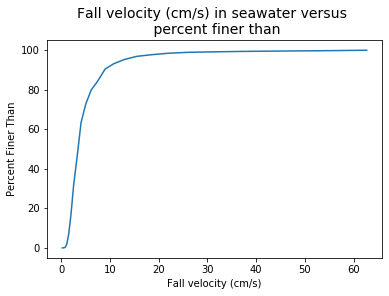

In [98]:
x = data['w_cm_s']
y = data['CumulativePercFiner']

plt.plot(x,y)

plt.xlabel('Fall velocity (cm/s)')
plt.ylabel("Percent Finer Than")
plt.title('Fall velocity (cm/s) in seawater versus \n percent finer than', fontsize = 14)



Text(0.5, 1.0, 'Fall velocity (cm/s) in seawater versus \n percent finer than, log-scale')

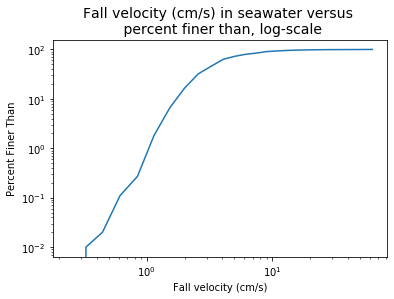

In [100]:
x = data['w_cm_s']
y = data['CumulativePercFiner']

plt.plot(x,y)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Fall velocity (cm/s)')
plt.ylabel("Percent Finer Than")

plt.title('Fall velocity (cm/s) in seawater versus \n percent finer than, log-scale', fontsize = 14)


## Discussion:
The fall velocity increases rapidly as percent finer than increases. Maximum fall veloicty was 62.7 cm /s for the grain size of 4 mm. The smallest grain size had a fall velocity of 0.2 cm/s which is incredibly slow, this sediment would be effectively suspended. This theoretical approach of computing the fall velocity required some assumptions. Namely, we are approximating the drag coefficient for sediment that is (1) perfectly spherical, (2) in water that is perfectly still  and that (3) entirely made of quartz. We need to assume that the sediment is comprised of perfect spheres so that we can assume that the drag and lift forces are orhogonal and the forces go to 0. In reality, this calculation is idealized. The sediment grains may be irregular and may not be perfectly smooth spheres, resulting in an unequal balance of forces and the true fall velocity curve would appear less smooth. We are also assuming the sediment is at terminal veloicty and therefore falling through smooth water. However, if these data are derived from an oceanic setting, wave motions and prevailing currents would also affect the velocity calculations. While quartz typically makes up 70% of beach minerals, also know that coastal sediment can be made of a mix of other minerals including feldspar, shell, coral, etc. Therefore, assuming a consistent specific gravity of 2.65 (quartz) is inconsistent with reality. 